# Spaceship Titanic Dataset with TensorFlow Decision Forests

In [77]:
import os, tensorflow as tf, tensorflow_decision_forests as tfdf, pandas as pd, numpy as np, seaborn as sb, matplotlib.pyplot as plt

In [78]:
dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
train_df, test_df = pd.read_csv(dir+'/data/raw/train.csv'), pd.read_csv(dir+'/data/raw/test.csv') 

In [79]:
print('Full train dataset shape is {}'.format(train_df.shape),'\nFull test dataset shape is {}'.format(test_df.shape))
#train_df.head(5) #test_df.head(5)
#train_df.describe()
#train_df.info()

Full train dataset shape is (8693, 14) 
Full test dataset shape is (4277, 13)


In [80]:
plt.figure()
plot_df = train_df.Transported.value_counts()
fig = plot_df.plot(kind="bar",figsize=(10,8),xlabel='Transported',ylabel='Passenger Count',title='Title').get_figure()
fig.savefig(dir+'/results/images/Bar_Transported_True-False.png')
plt.close()

'''
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sb.histplot(train_df['Age'], color='b', bins=50, ax=ax[0]);
sb.histplot(train_df['FoodCourt'], color='b', bins=50, ax=ax[1]);
sb.histplot(train_df['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sb.histplot(train_df['Spa'], color='b', bins=50, ax=ax[3]);
sb.histplot(train_df['VRDeck'], color='b', bins=50, ax=ax[4]);
'''

"\nfig, ax = plt.subplots(5,1,  figsize=(10, 10))\nplt.subplots_adjust(top = 2)\n\nsb.histplot(train_df['Age'], color='b', bins=50, ax=ax[0]);\nsb.histplot(train_df['FoodCourt'], color='b', bins=50, ax=ax[1]);\nsb.histplot(train_df['ShoppingMall'], color='b', bins=50, ax=ax[2]);\nsb.histplot(train_df['Spa'], color='b', bins=50, ax=ax[3]);\nsb.histplot(train_df['VRDeck'], color='b', bins=50, ax=ax[4]);\n"

6963 examples in training, 1730 examples in testing.
Use /var/folders/7p/t5ltv8ns6r36tgzp427b7cfm0000gn/T/tmp_ss6qb1s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.142529. Found 6963 examples.
Training model...


[INFO 23-08-22 09:32:33.7652 BST kernel.cc:1243] Loading model from path /var/folders/7p/t5ltv8ns6r36tgzp427b7cfm0000gn/T/tmp_ss6qb1s/model/ with prefix 6e8b47d48bd94ce4


Model trained in 0:00:15.756309
Compiling model...
Model compiled.


[INFO 23-08-22 09:32:34.1396 BST decision_forest.cc:660] Model loaded with 300 root(s), 236068 node(s), and 13 input feature(s).
[INFO 23-08-22 09:32:34.1397 BST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-08-22 09:32:34.1397 BST kernel.cc:1075] Use fast generic engine


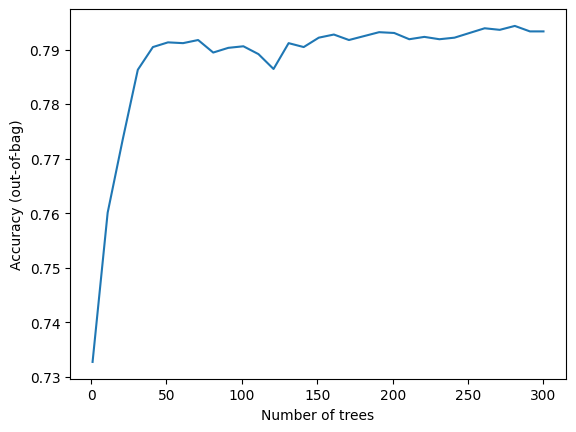

2/2 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - accuracy: 0.8012
loss: 0.0000
accuracy: 0.8012
Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES


[("CryoSleep" (1; #2), 113.0),
 ("RoomService" (1; #7), 81.0),
 ("Spa" (1; #10), 51.0),
 ("VRDeck" (1; #12), 30.0),
 ("ShoppingMall" (1; #8), 14.0),
 ("FoodCourt" (1; #5), 6.0),
 ("Deck" (4; #3), 3.0),
 ("HomePlanet" (4; #6), 2.0)]

In [81]:
train_df = train_df.drop(['PassengerId', 'Name'], axis=1)
train_df.head(5)

train_df.isnull().sum().sort_values(ascending=False)

train_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = train_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
train_df.isnull().sum().sort_values(ascending=False)

label = "Transported"
train_df[label] = train_df[label].astype(int)

train_df['VIP'] = train_df['VIP'].astype(int)
train_df['CryoSleep'] = train_df['CryoSleep'].astype(int)

train_df[["Deck", "Cabin_num", "Side"]] = train_df["Cabin"].str.split("/", expand=True)

try:
    train_df = train_df.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")
    
train_df.head(5)

def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(train_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label)

tfdf.keras.get_all_models()
rf = tfdf.keras.RandomForestModel()
rf.compile(metrics=["accuracy"]) # Optional, you can use this to include a list of eval metrics

rf.fit(x=train_ds)
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.savefig(dir+'/results/images/Accuracy_Tress.png')
plt.show()

inspector = rf.make_inspector()
inspector.evaluation()

evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")
  
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

In [82]:
# Load the test dataset
submission_id = test_df.PassengerId

# Replace NaN values with zero
test_df[['VIP', 'CryoSleep']] = test_df[['VIP', 'CryoSleep']].fillna(value=0)

# Creating New Features - Deck, Cabin_num and Side from the column Cabin and remove Cabin
test_df[["Deck", "Cabin_num", "Side"]] = test_df["Cabin"].str.split("/", expand=True)
test_df = test_df.drop('Cabin', axis=1)

# Convert boolean to 1's and 0's
test_df['VIP'] = test_df['VIP'].astype(int)
test_df['CryoSleep'] = test_df['CryoSleep'].astype(int)

# Convert pd dataframe to tf dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

# Get the predictions for testdata
predictions = rf.predict(test_ds)
n_predictions = (predictions > 0.5).astype(bool)
output = pd.DataFrame({'PassengerId': submission_id,
                       'Transported': n_predictions.squeeze()})

output.head()

sample_submission_df = pd.read_csv(dir+'/data/sample_submission.csv') 
sample_submission_df['Transported'] = n_predictions
sample_submission_df.to_csv(dir+'/results/data/submission.csv', index=False)
sample_submission_df.head()

5/5 [==============================] - 0s 40ms/step


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
